In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

from basin_volume import *

In [2]:
def make_kl_fn(probs_p, apply_fn, x, l2_reg):
    def kl_fn(a, b):
        params_q = a + b
        logits_q = apply_fn(params_q, x)
        logprobs_q = jax.nn.log_softmax(logits_q)
        kl_term = optax.kl_divergence(logprobs_q, probs_p).mean()
        l2_term = 1/2 * l2_reg * jnp.sum(b**2)
        return kl_term + l2_term
    return kl_fn

def make_kl_fn_params(params_p, apply_fn, x, *, l2_reg):
    logits_p = apply_fn(params_p, x)
    probs_p = jax.nn.softmax(logits_p)
    return make_kl_fn(probs_p, apply_fn, x, l2_reg=l2_reg)

## Model-specific setup

In [3]:
# we can set mesa_constrain=True and norm_scale=(float) to clamp the norm of the parameters
# instead, we'll add an L2 penalty to the loss function here:
cfg = MLPTrainConfig(train_size=1024, 
                     opt="adam", 
                     lr=.05,
                     l2_reg=5e-4,
                     d_inner=64*8,
                     num_layers=5,
                    )

In [4]:
# Train the model
# This needs a refactor -- all the messiness is hiding in training.py
# You don't need to worry about it to use this package with other models

final_params, state, apply_fn, X_train = train_mlp(cfg)

In [5]:
print(final_params.raveled.shape)

(1089034,)


In [6]:
kl_fn = make_kl_fn_params(final_params.raveled, apply_fn, X_train, l2_reg=0.)

In [7]:
# H = jax.hessian(kl_fn, argnums=0)(final_params.raveled, 0)

In [7]:
adam_state, _, schedule_state = state.opt_state
mu, nu = adam_state.mu['p'], adam_state.nu['p']

# standard deviation of the Gaussian we'll use to weight our estimates
sigma_epoch = 1/jnp.sqrt(cfg.l2_reg * cfg.train_size)

## Volume estimation

In [8]:
CUTOFF = 1e-2

RESULTS = {} # estimates, props, mults, deltas, logabsint

In [50]:
RESULTS['naive'] = get_estimates_vectorized_gauss(100, 
                                                  sigma=sigma_epoch,
                                                  fn=kl_fn, 
                                                  params=final_params.raveled, 
                                                  cutoff=CUTOFF,
                                                  tol=1e-2,
                                                  debug=True,
                                                 )


a.shape=()
b.shape=(100,)
c.shape=()
global_max=Array([1458.2854, 1458.4987, 1458.3925, 1458.3307, 1458.5936, 1458.3999,
       1458.6298, 1458.308 , 1458.2363, 1458.2874, 1458.2349, 1458.3783,
       1458.5746, 1458.3119, 1458.2704, 1458.4615, 1458.5243, 1458.3707,
       1458.6259, 1458.3809, 1458.2396, 1458.4254, 1458.4403, 1458.5597,
       1458.3274, 1458.4525, 1458.5555, 1458.705 , 1458.4371, 1458.5585,
       1458.391 , 1458.5563, 1458.3306, 1458.4663, 1458.609 , 1458.2739,
       1458.1592, 1458.3799, 1458.3462, 1458.5254, 1458.5493, 1458.3639,
       1458.4984, 1458.6577, 1458.5818, 1458.7068, 1458.6888, 1458.5294,
       1458.4023, 1458.4158, 1458.4612, 1458.473 , 1458.3833, 1458.6617,
       1458.5071, 1458.4944, 1458.4309, 1458.4868, 1458.3652, 1458.2925,
       1458.3171, 1458.3136, 1458.4684, 1458.3998, 1458.3156, 1458.4343,
       1458.4285, 1458.2277, 1458.2546, 1458.248 , 1458.538 , 1458.465 ,
       1458.4202, 1458.3728, 1458.3306, 1458.3254, 1458.3198, 1458.5071,
   

ValueError: Approximation error too high, raise tol or use quad

In [18]:
Array = jnp.array
float32 = jnp.float32

In [42]:
gaussint_ln_noncentral_erf(a=0.5120001, b=-0.03600831, n=1089033, x1=28.148438, c=-15347.044)

Array(3619077.2, dtype=float32)

In [51]:
a= 0.5120000839233398
b= -0.14776533842086792
n= 1089033
x1= 32.42888259887695
c= -15347.0439453125
debug = True
tol = 1e-2

mu = b / a
center = mu / 2
dist = jnp.sqrt(mu**2 + 4 * n / a) / 2
global_max = center + dist
global_in_range = global_max <= x1
if debug:
    print(f"{global_max=}, {global_in_range=}")
max_pt = jnp.minimum(global_max, x1)
# get approximation stuff
log_fn = log_fn_factory(a, b, n)
dlog_fn = dlog_fn_factory(a, b, n)
d2log_fn = d2log_fn_factory(a, b, n)
f0 = log_fn(max_pt)
f1 = dlog_fn(max_pt)
f2 = d2log_fn(max_pt)
approx_log_fn = lambda x: f0 + f1 * (x - max_pt) + 1/2 * f2 * (x - max_pt)**2

# global in range:
# extrapolate down by tol
y_tol = -jnp.log(tol)
rad_global = jnp.sqrt(2 * y_tol / -f2)
check_low_global = jnp.clip(max_pt - rad_global, 0, x1)
check_high_global = jnp.clip(max_pt + rad_global, 0, x1)
# check approximation error at those points
error_low_global = log_fn(check_low_global) - approx_log_fn(check_low_global)
error_high_global = log_fn(check_high_global) - approx_log_fn(check_high_global)
abs_error_global = jnp.maximum(jnp.abs(error_low_global), jnp.abs(error_high_global))

# global out of range:
# extrapolate down by tol
rad_x1 = f1 / -f2 - jnp.sqrt(f1**2 / f2**2 + 2 * y_tol / -f2)

global_max=Array(1458.2854, dtype=float32, weak_type=True), global_in_range=Array(False, dtype=bool, weak_type=True)


In [52]:
print(rad_x1)
print(f1 / -f2, - jnp.sqrt(f1**2 / f2**2 + 2 * y_tol / -f2))

-0.0001335144
32.39669 -32.396824


In [53]:
-y_tol / f1

Array(-0.0001372, dtype=float32, weak_type=True)

In [55]:
f0, f1, f2

(Array(3788525.8, dtype=float32, weak_type=True),
 Array(33565.44, dtype=float32, weak_type=True),
 Array(-1036.0763, dtype=float32, weak_type=True))

In [38]:
(jnp.abs(f1/-f2), jnp.abs(y_tol / f1))

(Array(28.127447, dtype=float32, weak_type=True),
 Array(0.00011908, dtype=float32, weak_type=True))

In [63]:
f012_int_ln(max_pt, x1, f0, f1, f2, debug=debug) + c

upper=Array(3788515.2, dtype=float32), lower=Array(2155239.2, dtype=float32)


Array(3773168.2, dtype=float32)

In [70]:
print(f"{max_pt = }\n{x1 = }\n{f0 = }\n{f1 = }\n{f2 = }\n{c = }")
print(f"{(x1 - max_pt).item() =}")

max_pt = Array(32.428883, dtype=float32, weak_type=True)
x1 = 32.42888259887695
f0 = Array(3788525.8, dtype=float32, weak_type=True)
f1 = Array(33565.44, dtype=float32, weak_type=True)
f2 = Array(-1036.0763, dtype=float32, weak_type=True)
c = -15347.0439453125
(x1 - max_pt).item() =0.0


In [71]:
x1 == max_pt

Array(True, dtype=bool, weak_type=True)

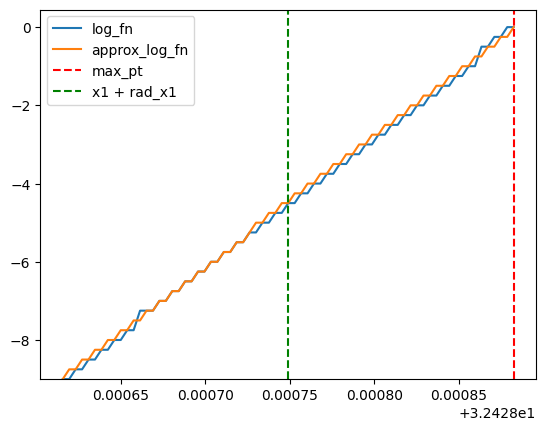

In [62]:
xs = jnp.linspace(x1 + 2 * rad_x1, x1, 1000)
plt.plot(xs, log_fn(xs) - log_fn(max_pt), label="log_fn")
plt.plot(xs, approx_log_fn(xs) - log_fn(max_pt), label="approx_log_fn")
plt.ylim(bottom=(approx_log_fn(xs).min() - log_fn(max_pt)))
plt.axvline(x=x1, color='r', linestyle='--', label="max_pt")
plt.axvline(x=x1 + rad_x1, color='g', linestyle='--', label="x1 + rad_x1")
plt.legend()
plt.show()

In [ ]:
final_params.raveled.shape

(1089034,)

In [52]:
P_adam_mu = diag_preconditioner(mu, eps=4e-3, exponent=0.3)
RESULTS['adam_mu'] = get_estimates_vectorized_gauss(100, 
                                                    sigma=sigma_epoch,
                                                    preconditioner=P_adam_mu, 
                                                    fn=kl_fn, 
                                                    params=final_params.raveled, 
                                                    cutoff=CUTOFF,
                                                    tol=10,
                                                    )


2024-12-13 02:42:03.742735: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below -4.07TiB (-4470416519688 bytes) by rematerialization; only reduced to 4.31TiB (4743980212624 bytes), down from 4.31TiB (4743980212624 bytes) originally
2024-12-13 02:42:03.744528: E external/xla/xla/status_macros.cc:56] INTERNAL: RET_CHECK failure (external/xla/xla/service/gpu/fusions/fusion_emitter.cc:95) device_info.block_dim_limit().x == 0 || launch_dims.block_counts().x < device_info.block_dim_limit().x Kernel 'loop_select_fusion' launch needs more blocks (2316396589) than allowed by hardware (2147483647).
*** Begin stack trace ***
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	
	PyObject_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	_PyEval_EvalFrameDefault
	_PyFunction_Vectorcall
	PyObject_Vectorcall
	
	
	
	
	
	_PyObject_FastCallDictTstate
	_PyObject_Call_Prepend
	
	_PyObject_MakeTpCall
	_PyEval_EvalFrameDefault
	_PyF

XlaRuntimeError: INTERNAL: RET_CHECK failure (external/xla/xla/service/gpu/fusions/fusion_emitter.cc:95) device_info.block_dim_limit().x == 0 || launch_dims.block_counts().x < device_info.block_dim_limit().x Kernel 'loop_select_fusion' launch needs more blocks (2316396589) than allowed by hardware (2147483647).

In [19]:
P_adam_nu = diag_preconditioner(nu, eps=2e-3, exponent=0.3)
RESULTS['adam_nu'] = get_estimates_vectorized_gauss(3000, 
                                                    sigma=sigma_epoch,
                                                    preconditioner=P_adam_nu, 
                                                    fn=kl_fn, 
                                                    params=final_params.raveled, 
                                                    cutoff=CUTOFF)


## Plots

In [21]:
def scaled_histogram(values, label, settings):
    nbins = int(jnp.sqrt(len(values)))
    # if label == 'hessian':
    #     nbins = 5
    counts, bins = jnp.histogram(values, bins=nbins)
    counts = counts / counts.max()
    plt.stairs(counts, bins, **dict(settings, label=label))

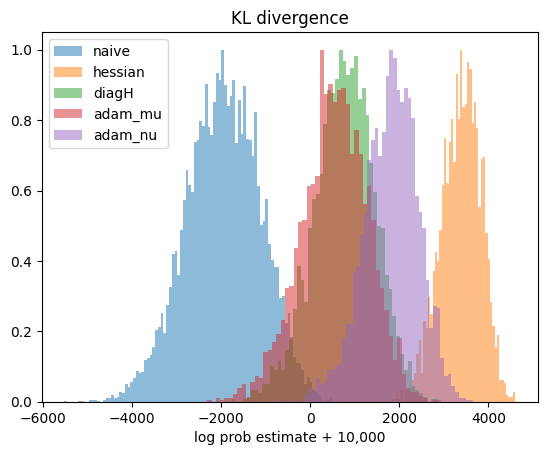

In [23]:
settings = {'alpha': 0.5, 'fill': True}
for label, results in RESULTS.items():
    # if label in ['hessian', 'adam_mu']:
    #     continue
    these_settings = dict(settings, label=label)
    scaled_histogram(results[0] + 10_000, label, these_settings)
plt.xlabel("log prob estimate + 10,000")
plt.legend()
plt.title("KL divergence")
plt.show()